## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
import numpy as np
import math as ma
from numba import cuda
import math
from numba import vectorize, int64, float32,int16


In [2]:
@vectorize([float32(float32)], target='parallel') 
def log_v(x):
    return ma.log(x)


@vectorize([float32(float32)], target='parallel') 
def exp_v(x):
    return ma.exp(x)

In [3]:
A=[2,5,10,3,8]
A=np.array(A).astype(np.float32)
print(log_v(A))
print(exp_v(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [26]:
def compute_gaus(mu,sig,bound,size):
    x = np.linspace(bound[0],bound[1],size)
    return 1/np.sqrt(2*np.pi)*np.exp(((x-mu)**2)/2) 

%time compute_gaus(1,1,(-3,3),100000)

from numba import njit,jit

@njit
def compute_gaus(mu,sig,bound,size):
    x = np.linspace(bound[0],bound[1],size)
    return 1/np.sqrt(2*np.pi)*np.exp(((x-mu)**2)/2) 

%time compute_gaus(1,1,(-3,3),100000)

CPU times: user 3.21 ms, sys: 455 µs, total: 3.67 ms
Wall time: 4.67 ms
CPU times: user 260 ms, sys: 2.6 ms, total: 263 ms
Wall time: 262 ms


array([1189.23017713, 1188.94479542, 1188.65948648, ...,    2.94709952,
          2.94745318,    2.94780689])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

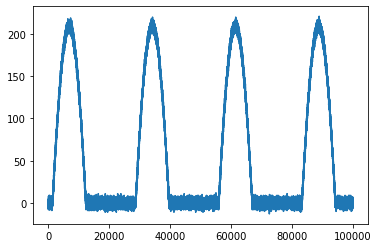

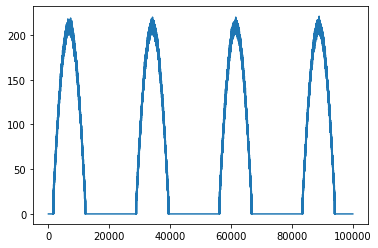

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

@vectorize([int16(int16)]) 
def zero_supp(x):
    if x < 15: x=0
    return x


n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

plt.plot(data)
plt.figure()
plt.plot(zero_supp(data))
#put your code here
    

In [34]:
a=np.random.random(100_000_000).astype(np.int16)
@vectorize([int16(int16)], target='parallel') 
def zero_supp(x):
    if x < 15: x=0
    return x

%time zero_supp(a)

@vectorize([int16(int16)]) 
def zero_supp(x):
    if x < 15: x=0
    return x

%time zero_supp(a)
%time a[a<15 ]=0

def zero_supp(x):
    if x < 15: x=0
    return x

CPU times: user 1.74 s, sys: 56.8 ms, total: 1.8 s
Wall time: 503 ms
CPU times: user 20.9 ms, sys: 23.7 ms, total: 44.6 ms
Wall time: 44.6 ms
CPU times: user 89.5 ms, sys: 20.4 ms, total: 110 ms
Wall time: 109 ms


## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [6]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

k=np.tanh(1+np.dot(X.T,Y)+1)
k

array([[0.99692985, 0.98672588, 0.98188886],
       [0.99206991, 0.97834742, 0.97670844],
       [0.99105618, 0.97510559, 0.97658689]])

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [7]:
%%time

# CUDA kernel
@cuda.jit
def cos_kernel_3D(matrix):
    x, y, z = cuda.grid(3)
    if x < matrix.shape[0] and y < matrix.shape[1] and z < matrix.shape[2]:
        matrix[x][y][z] = np.cos(matrix[x][y][z])

# Host code   
data = np.ones((64,64,64))

# Configure the blocks
threadsperblock = (32, 32, 32) 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cos_kernel_3D[blockspergrid, threadsperblock](data)
print(data)

[[[0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  ...
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]]

 [[0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  ...
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]]

 [[0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.540302

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [12]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.random((24,12))
B = np.random.random((12,22))
C = np.zeros((24,22))


threadsperblock = (32, 32) 
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))

blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

[[3.20969217 4.11185463 3.65819123 3.25776884 2.87785276 3.22781944
  2.65591098 2.17398986 4.73864948 4.3088471  4.01047522 3.50024594
  3.70167568 3.12599764 3.55097832 3.54268235 3.29070278 3.46734546
  2.55335588 3.16567218 2.60923465 3.01520355]
 [2.25345128 3.51013133 2.56466747 2.50212534 2.34149058 2.20089193
  2.39499218 1.74614445 3.3071802  2.76793651 2.35356653 2.66421549
  2.62610423 2.92390643 2.68113764 2.45257791 2.8873406  3.0659704
  2.05364305 2.56431719 2.24289398 1.66449874]
 [3.13397649 3.67821744 3.22794722 3.23592853 2.81886366 3.1938024
  2.75231622 2.27799303 5.06706532 3.42873652 4.02394827 3.82766094
  3.55441688 3.58772538 3.88006526 3.97035339 3.61627501 3.86523468
  2.58781063 3.6582771  3.28785052 3.42140352]
 [2.3463378  2.99071636 2.67996982 2.46464381 2.24117376 2.27911117
  2.26943386 1.52910055 3.79462188 2.60098983 2.90615051 2.71538462
  3.19222964 2.71775069 2.90504636 2.95794294 2.84306485 2.80919741
  2.19899522 2.41461106 2.04721798 2.3309021 

In [37]:
%time matmul[blockspergrid, threadsperblock](A,B,C)
%time np.dot(A,B)

CPU times: user 189 ms, sys: 21.5 ms, total: 210 ms
Wall time: 183 ms
CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 32.4 µs


array([[3.20969217, 4.11185463, 3.65819123, 3.25776884, 2.87785276,
        3.22781944, 2.65591098, 2.17398986, 4.73864948, 4.3088471 ,
        4.01047522, 3.50024594, 3.70167568, 3.12599764, 3.55097832,
        3.54268235, 3.29070278, 3.46734546, 2.55335588, 3.16567218,
        2.60923465, 3.01520355],
       [2.25345128, 3.51013133, 2.56466747, 2.50212534, 2.34149058,
        2.20089193, 2.39499218, 1.74614445, 3.3071802 , 2.76793651,
        2.35356653, 2.66421549, 2.62610423, 2.92390643, 2.68113764,
        2.45257791, 2.8873406 , 3.0659704 , 2.05364305, 2.56431719,
        2.24289398, 1.66449874],
       [3.13397649, 3.67821744, 3.22794722, 3.23592853, 2.81886366,
        3.1938024 , 2.75231622, 2.27799303, 5.06706532, 3.42873652,
        4.02394827, 3.82766094, 3.55441688, 3.58772538, 3.88006526,
        3.97035339, 3.61627501, 3.86523468, 2.58781063, 3.6582771 ,
        3.28785052, 3.42140352],
       [2.3463378 , 2.99071636, 2.67996982, 2.46464381, 2.24117376,
        2.2791111